## Journal used for the implemetation
**Journal title**: Hybrid CNN-GRU Model for Real-Time Blood Glucose
Forecasting: Enhancing IoT-Based Diabetes Management with AI

**Authors**: Reem Ibrahim Alkanhel, Hager Saleh, Ahmed Elaraby, Saleh Alharbi, Hela Elmannai, Saad Alaklabi, Saeed Hamood Alsamhi and Sherif Mostafa

**Journal Name**: Sensors (published by MDPI)

**Year**: 2024

# 1. Import the required libraries

In [ ]:
##---------Type the code below this line------------------##
!pip install keras-tuner
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GRU, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from kerastuner.tuners import BayesianOptimization
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns

# 2. Data Acquisition

For the problem identified by you, students have to find the data source themselves from any data source.

Provide the URL of the data used.

Write Code for converting the above downloaded data into a form suitable for DL



In [ ]:
##---------Type the code below this line------------------##
# Load the dataset from Google Drive
drive_link = "https://drive.google.com/file/d/1-1Th0f4ssvmbC1hnwLMXzENLlxNWZJYe/view?usp=sharing"
file_id = drive_link.split("/d/")[1].split("/view")[0]
download_url = f"https://drive.google.com/uc?id={file_id}"

# Read CSV and check column names
df = pd.read_csv(download_url)
df.columns = df.columns.str.strip()  # Remove hidden spaces
print("Columns in dataset:", df.columns)

# Check if 'Time' column exists
if 'Time' not in df.columns:
    print("Warning: 'Time' column not found! Trying to use the first column as timestamps.")
    df.rename(columns={df.columns[0]: 'Time'}, inplace=True)

# Convert 'Time' column to datetime
df['Time'] = pd.to_datetime(df['Time'], errors='coerce')
df.dropna(subset=['Time'], inplace=True)  # Drop rows where 'Time' conversion failed
df.set_index('Time', inplace=True)

# Ensure 'BGL' column exists
bgl_column = 'BGL' if 'BGL' in df.columns else df.columns[1]  # Use second column if 'BGL' is missing
print(f"Using '{bgl_column}' as BGL column.")


# 3. Data Preparation

Perform the data prepracessing that is required for the data that you have downloaded.


This stage depends on the dataset that is used.

In [ ]:
##---------Type the code below this line------------------##

# Normalize the BGL data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[[bgl_column]])

# Create sequences for time-series forecasting
def create_sequences(data, seq_length, pred_length):
    X, y = [], []
    for i in range(len(data) - seq_length - pred_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length:i+seq_length+pred_length])
    return np.array(X), np.array(y)

seq_length = 30  # Time steps used for input
pred_length = 5  # Future steps to predict
X, y = create_sequences(scaled_data, seq_length, pred_length)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)

## Split the data into training set and testing set
##---------Type the code below this line------------------##

# Create sequences for time-series forecasting
def create_sequences(data, seq_length, pred_length):
    X, y = [], []
    for i in range(len(data) - seq_length - pred_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length:i+seq_length+pred_length])
    return np.array(X), np.array(y)

seq_length = 30  # Time steps used for input
pred_length = 5  # Future steps to predict
X, y = create_sequences(scaled_data, seq_length, pred_length)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)

## Identify the target variables.
##---------Type the code below this line------------------##

# Ensure 'BGL' column exists
bgl_column = 'BGL' if 'BGL' in df.columns else df.columns[1]  # Use second column if 'BGL' is missing
print(f"Using '{bgl_column}' as BGL column.")



## 4. Deep Neural Network Architecture


## 4.1 Design the architecture that you will be using

* CNN / RNN / Transformer as per the journal referenced



In [ ]:
##---------Type the code below this line------------------##
def build_model(hp):
    model = Sequential()

    # CNN layers
    model.add(Conv1D(filters=hp.Int('filters', min_value=128, max_value=250, step=32),
                     kernel_size=hp.Int('kernel_size', min_value=3, max_value=4),
                     activation='relu',
                     input_shape=(X_train.shape[1], X_train.shape[2])))  # Input shape: (seq_length, 1)
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)))

    # GRU layers
    model.add(GRU(units=hp.Int('units', min_value=50, max_value=500, step=50),
                  activation='relu',
                  return_sequences=False))
    model.add(Dropout(hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)))

    # Fully connected layers
    model.add(Dense(units=pred_length, activation='linear'))

    # Compile the model
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    return model

## 4.2 DNN Report

Report the following and provide justification for the same.

* Number of layers

Number of Layers: The model has 6 layers (Conv1D, MaxPooling1D, Dropout, GRU, Dropout, Dense).

Number of Units/Filters:

Conv1D layer has 128 filters.

GRU layer has 128 units.

Dense layer has 5 units


* Number of units in each layer

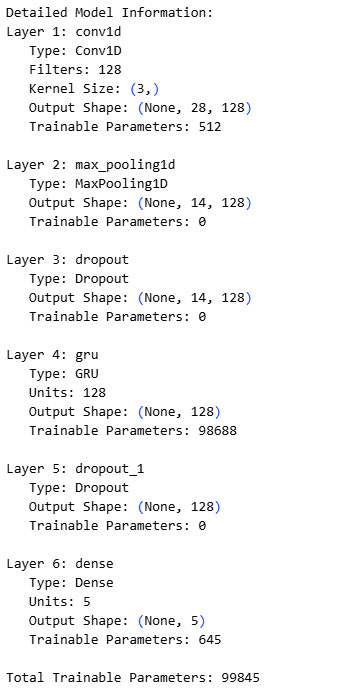



* Total number of trainable parameters

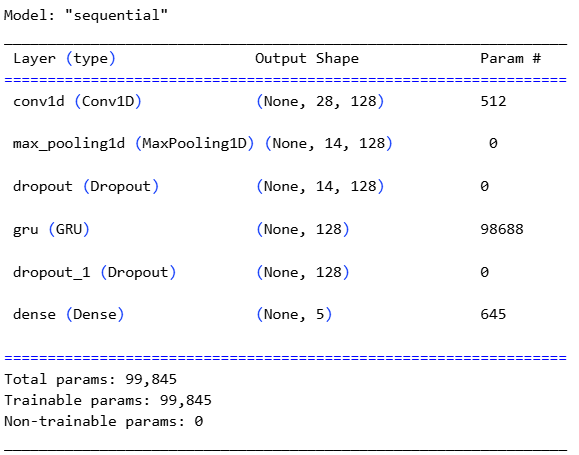    



##Justification for the Architecture

##Conv1D Layer:

Used to extract local patterns from the time-series data.

128 filters allow the model to learn a wide range of features.

##MaxPooling1D Layer:

Reduces the dimensionality of the data, making the model more computationally efficient.

##Dropout Layers:

Added to prevent overfitting by randomly dropping units during training.

##GRU Layer:

Captures temporal dependencies in the time-series data.

128 units provide sufficient capacity to learn complex patterns.

##Dense Layer:

Produces the final output (5 units for predicting 5 future time steps).

# 5. Training the model


In [ ]:
# Configure the training, by using appropriate optimizers, regularizations and loss functions
##---------Type the code below this line------------------##

# Hyperparameter tuning using Bayesian Optimization
tuner = BayesianOptimization(
    build_model,
    objective='val_loss',
    max_trials=5,
    executions_per_trial=2,
    directory='tuner_results',
    project_name='cnn_gru_tuning'
)

tuner.search(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Train the best model
history = best_model.fit(X_train, y_train, epochs=10, batch_size=1, validation_data=(X_test, y_test))

# Print the model summary
print("\nModel Summary:")
best_model.summary()

# Extract and print detailed information about each layer
print("\nDetailed Model Information:")
for i, layer in enumerate(best_model.layers):
    print(f"Layer {i + 1}: {layer.name}")
    print(f"   Type: {layer.__class__.__name__}")
    if hasattr(layer, 'units'):
        print(f"   Units: {layer.units}")
    if hasattr(layer, 'filters'):
        print(f"   Filters: {layer.filters}")
    if hasattr(layer, 'kernel_size'):
        print(f"   Kernel Size: {layer.kernel_size}")
    print(f"   Output Shape: {layer.output_shape}")
    print(f"   Trainable Parameters: {layer.count_params()}")
    print()

# Total number of trainable parameters
total_trainable_params = best_model.count_params()
print(f"Total Trainable Parameters: {total_trainable_params}")


# Plot Training and Validation Loss History
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot Training and Validation MAE History
plt.figure(figsize=(10, 5))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Training and Validation MAE History')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

# 6. Test the model


In [ ]:
##---------Type the code below this line------------------##
# Evaluate the model
loss, mae = best_model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test MAE: {mae}")

# Make predictions
predictions = best_model.predict(X_test)

# **FIX: Ensure shapes match before inverse transformation**
y_test_actual = y_test.reshape(-1, pred_length)  # Match to (n_samples, pred_length)
predictions = predictions.reshape(-1, pred_length)

# Inverse transform using the original scaler
y_test_actual = scaler.inverse_transform(y_test_actual)
predictions = scaler.inverse_transform(predictions)

# 7. Report the result

1. Plot the training and validation accuracy history.

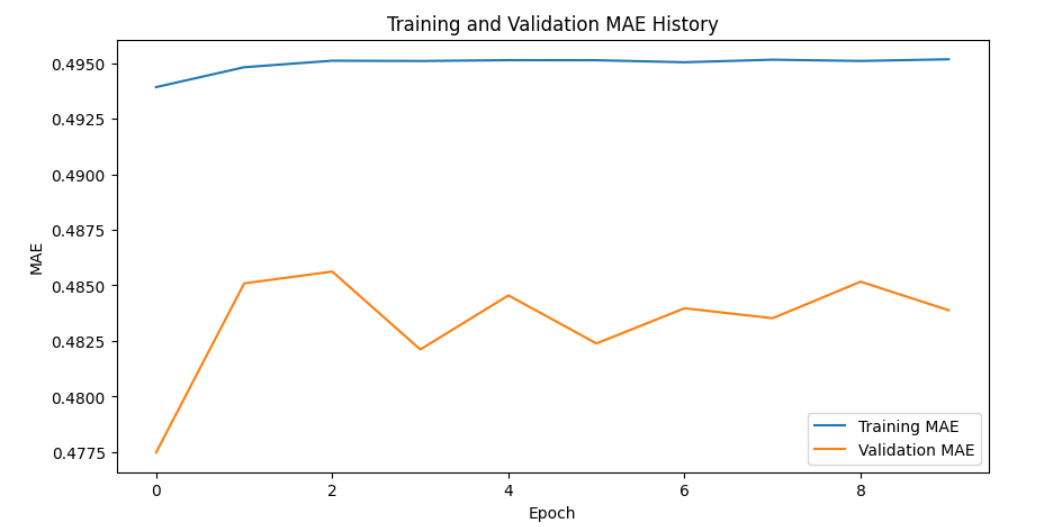
2. Plot the training and validation loss history.

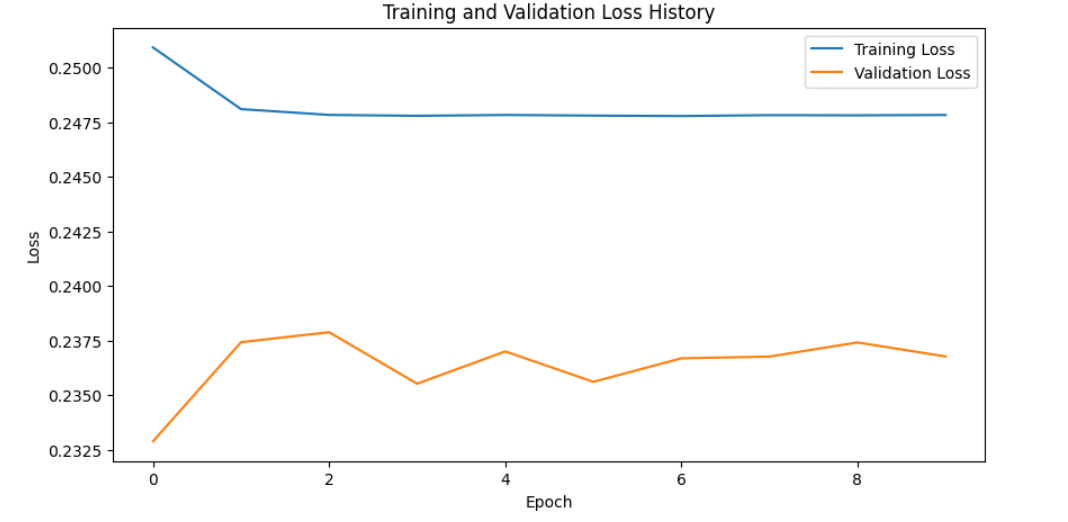

3. Report the testing accuracy and loss.

158/158 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.2401 - mae: 0.4872

Test Loss: 0.2367783486843109

Test MAE: 0.48387598991394043


4. Show Confusion Matrix for testing dataset.

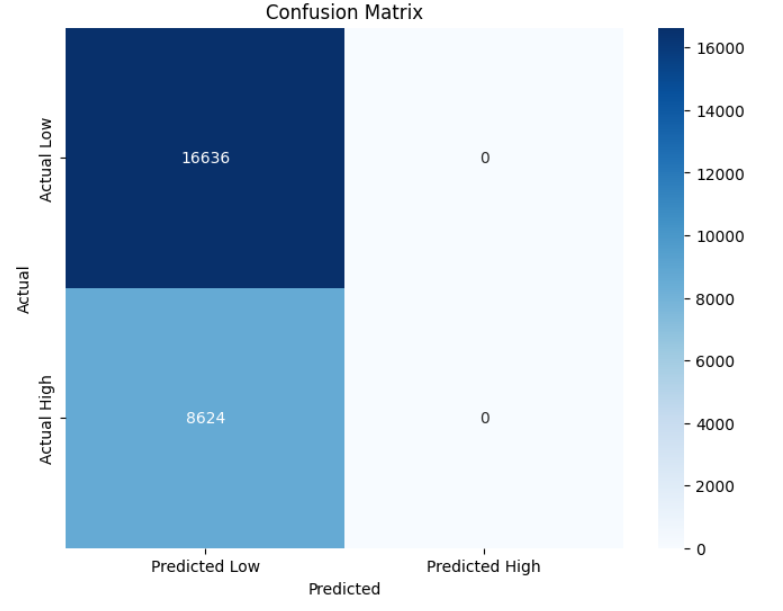

5. Report values for preformance study metrics like accuracy, precision, recall, F1 Score.

158/158 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step

Accuracy: 0.658590657165479

Precision: 0.43374165370565754

Recall: 0.658590657165479

F1 Score: 0.5230243542393025


In [ ]:
##---------Type the code below this line------------------##
# Flatten predictions and actual values for classification metrics
y_test_flat = y_test_actual.flatten()
predictions_flat = predictions.flatten()

# Calculate performance metrics
accuracy = accuracy_score(y_test_flat.round(), predictions_flat.round())
precision = precision_score(y_test_flat.round(), predictions_flat.round(), average='weighted')
recall = recall_score(y_test_flat.round(), predictions_flat.round(), average='weighted')
f1 = f1_score(y_test_flat.round(), predictions_flat.round(), average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test_flat.round(), predictions_flat.round())
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Low', 'Predicted High'], yticklabels=['Actual Low', 'Actual High'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### NOTE


All Late Submissions will incur a <b>penalty of -2 marks </b>. So submit your assignments on time.

Good Luck